In [2]:
import numpy as np
from scipy import signal
from sklearn.cluster import dbscan
import matplotlib.pyplot as plt

100


ValueError: x and y must have same first dimension, but have shapes (19999,) and (19900,)

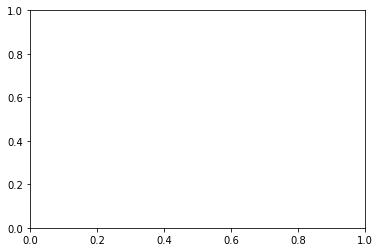

In [3]:


# DAQ Sampling parameters.
fs = 4000 # Sampling rate (Hz)
dt = 1 / fs # Time step (s)
T = 5 # Total time (t)
L = int(T / dt) # Number of points.

# Sensor sampling parameters.
dt_s = 2.5 * 10e-3
fs_s = 1 / dt_s
L_s = T / dt_s

# Sensor time and signal.
t_s = np.arange(0, T - dt_s, dt_s)
y_s = np.sin(np.pi * t_s)

# DAQ samples.
n_daq_per_s = int(fs / fs_s)
print(n_daq_per_s)
y = []
for i, y_samp in enumerate(y_s):
    # Simulate daq reading.
    y_samp_daq = np.random.normal(y_samp, 0.05, size=(n_daq_per_s))
    y.extend(y_samp_daq)

# Convert to numpy array.
y = np.array(y)

# DAQ time.
t = np.arange(0, T - dt, dt)

# Add some noise.
y = y + np.random.normal(0, 0.05, size=(y.shape))
plt.plot(t, y)
plt.show()

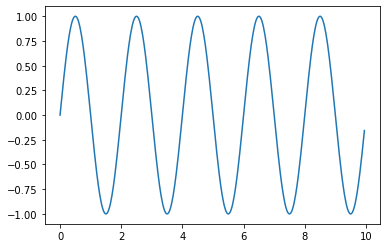

In [29]:
# Sensor sampling parameters.
dt = 2.5 * 10e-3
fs = 1 / dt
T = 10
L = int(T / dt)

# Sensor time and signal.
t = np.arange(0, T - dt, dt)
y = np.sin(np.pi * t)
# y[::3] -= 0.4
# y[::4] += 0.4
# y[:int(L/3):3] -= 1
# y[int(2*L/3)::3] -= 1

plt.plot(t, y)

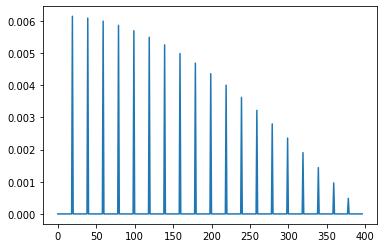

{31: -16, 30: -15, 29: -14, 28: -13, 27: -12, 26: -11, 25: -10, 24: -9, 23: -8, 22: -7, 21: -6, 20: -5, 19: -4, 18: -3, 17: -2, 16: -1, 15: 0, 14: 1, 13: 2, 12: 3, 11: 4, 10: 5, 9: 6, 8: 7, 7: 8, 6: 9, 5: 10, 4: 11, 3: 12, 2: 13, 1: 14, 0: 15}
[-0.07653669 -0.07130707 -0.06850806 -0.06528669 -0.0616628  -0.05765873
 -0.05329918 -0.04861103 -0.04362317 -0.03836636 -0.03287301 -0.02717698
 -0.0213134  -0.01531842 -0.00922899 -0.00308267  0.00308267  0.00922899
  0.01531842  0.0213134   0.02717698  0.03287301  0.03836636  0.04362317
  0.04861103  0.05329918  0.05765873  0.0616628   0.06528669  0.06850806
  0.07130707  0.07646666]
[31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10  9  8
  7  6  5  4  3  2  1  0]
16


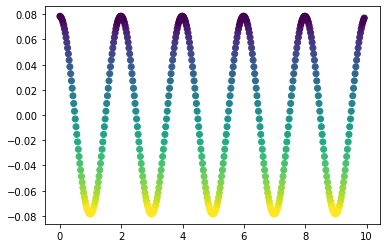

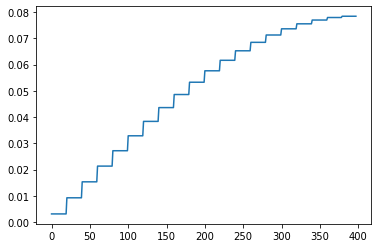

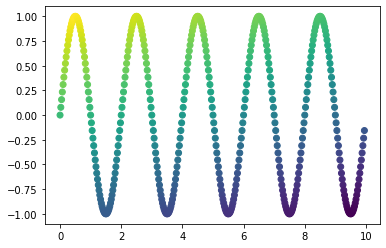

In [30]:
# Take the differences of y.
t_diff = t[:-1]
y_diff = np.diff(y)

# Shifts beyond a certain value.
threshold = 0.01
# Sort the data
sorted_diff = np.sort(abs(y_diff))
sorted_diff_diff = np.diff(sorted_diff)
shift = np.max(sorted_diff_diff)

plt.plot(sorted_diff_diff)
plt.show()

# DBScan data.
core_samples, labels = dbscan(y_diff.reshape(-1, 1), eps=shift/3)

# Label that corresponds to 0.
unique_labels = np.unique(labels)
label_means = np.zeros(len(unique_labels))
for i, ul in enumerate(unique_labels):
    label_means[i] = np.mean(y_diff[labels == ul])

# Sort unique labels by label means.
sort_label_means = np.sort(label_means)
label_mean_sort_idx = np.argsort(label_means)
sort_unique_labels = unique_labels[label_mean_sort_idx]

# Index of label mean closest to 0.
zero_idx = np.argmin(np.abs(sort_label_means - 0))

# Shift indices.
shift_lookup = dict(zip(sort_unique_labels, np.array(range(-zero_idx, zero_idx + 1))))
print(shift_lookup)
print(sort_label_means)
print(sort_unique_labels)
print(zero_idx)
shift_idx = np.array([shift_lookup[l] for l in labels])

# Labels for y.
y_labels = np.cumsum(np.insert(shift_idx, 0, 0))
y_labels += np.abs(np.min(y_labels)) # Index from 0


plt.scatter(t_diff,  y_diff, c=labels)
plt.show()

plt.plot(sorted_diff)
plt.show()

plt.scatter(t, y, c=y_labels)




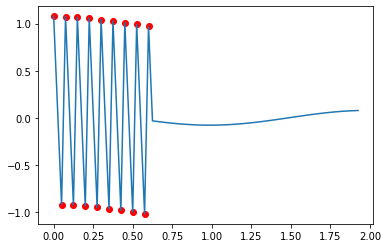

In [160]:
# Find square wave shifts.

# # Mean and variance.
# y_diff_mean = np.mean(y_diff)
# y_diff_std = np.std(y_diff)

# Outliers beyond 6-sigma.
shift_idxs = np.where(np.abs(y_diff) > 0.5)[0]
t_shift = t_diff[shift_idxs]
y_shift = y_diff[shift_idxs]

plt.plot(t_diff, y_diff)
plt.scatter(t_shift, y_shift, c='r')
plt.show()

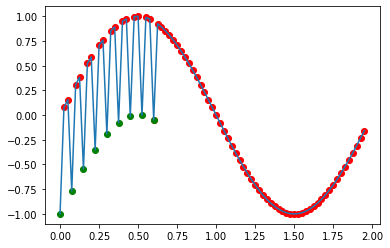

In [ ]:
# Process data into upper and lower.
data_upper = np.zeros((0, 2))
data_lower = np.zeros((0, 2))

# First shift.
shift = y_shift[0]
shift_times = t[:shift_idxs[0]+1]
shift_data = y[:shift_idxs[0]+1]
shift_array = np.column_stack((shift_times, shift_data))
if np.sign(shift) < 0:
    # Shift upper.
    data_upper = np.row_stack((data_upper, shift_array))
else:
    # Shift lower.
    data_lower = np.row_stack((data_lower, shift_array))

# Middle shifts
for i in range(len(y_shift)-1):
    # Data following shift.
    shift = y_shift[i]
    shift_times = t[shift_idxs[i]+1:shift_idxs[i+1]+1]
    shift_data = y[shift_idxs[i]+1:shift_idxs[i+1]+1]
    shift_array = np.column_stack((shift_times, shift_data))

    if np.sign(shift) > 0:
        # Shift upper.
        data_upper = np.row_stack((data_upper, shift_array))
    else:
        # Shift lower.
        data_lower = np.row_stack((data_lower, shift_array))

# Last shift.
shift = y_shift[-1]
shift_times = t[shift_idxs[-1]:]
shift_data = y[shift_idxs[-1]:]
shift_array = np.column_stack((shift_times, shift_data))
if np.sign(shift) > 0:
    # Shift upper.
    data_upper = np.row_stack((data_upper, shift_array))
else:
    # Shift lower.
    data_lower = np.row_stack((data_lower, shift_array))

plt.plot(t, y)
plt.scatter(data_upper[:,0], data_upper[:,1], c='r')
plt.scatter(data_lower[:,0], data_lower[:,1], c='g')
plt.show()

In [26]:
def filter_reflections(y):
    """
    Filter Banner s18uuaq sensor data for reflections which show up as regular voltage jumps in the data.

    Parameter
        y : Sensor data read through a DAQ at the same sampling rate as the sensor.
    Return
        y_labels : Labels for y indexed from 0 where each label corresponds to a reflection level.
    """
    # Take the differences of y.
    y_diff = np.diff(y)

    # Sort the differences.
    sorted_diff = np.sort(abs(y_diff))

    # Difference the sorted differences.
    sorted_diff_diff = np.diff(sorted_diff)

    # Sort again.
    sorted_sorted_diff_diff = np.sort(sorted_diff_diff)

    # Find the maximum difference. This is the estimate of the shift.
    shift = np.max(sorted_diff_diff)
    shift = sorted_sorted_diff_diff[-1]

    # DBScan data.
    _, labels = dbscan(y_diff.reshape(-1, 1), eps=shift/3)

    # Compute means of differences with each label.
    unique_labels = np.unique(labels)
    label_means = np.zeros(len(unique_labels))
    for i, ul in enumerate(unique_labels):
        label_means[i] = np.mean(y_diff[labels == ul])

    # Sort unique labels by label means.
    sort_label_means = np.sort(label_means)
    label_mean_sort_idx = np.argsort(label_means)
    sort_unique_labels = unique_labels[label_mean_sort_idx]

    # Index of label mean closest to 0.
    zero_idx = np.argmin(np.abs(sort_label_means - 0))

    # Shift indices.
    shift_lookup = dict(zip(sort_unique_labels, np.array(range(-zero_idx, zero_idx + 1))))
    shift_idx = np.array([shift_lookup[l] for l in labels])

    # Labels for y.
    y_labels = np.cumsum(np.insert(shift_idx, 0, 0))
    y_labels += np.abs(np.min(y_labels)) # Index from 0

    return y_labels

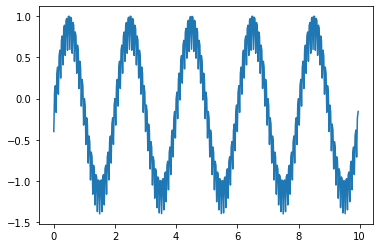

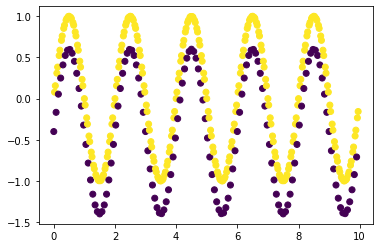

In [27]:
# Sensor sampling parameters.
dt = 2.5 * 10e-3
fs = 1 / dt
T = 10
L = int(T / dt)

# Sensor time and signal.
t = np.arange(0, T - dt, dt)
y = np.sin(np.pi * t)
y[::3] -= 0.4
# y[::4] += 0.4
# y[:int(L/3):3] -= 1
# y[int(2*L/3)::3] -= 1

plt.plot(t, y)
plt.show()

y_labels = filter_reflections(y)
plt.scatter(t, y, c=y_labels)